In [1]:
#### code to check what is in the files HALO and TRRL
#### author CLaudia Acquistapace
#### goal:  check what is in the files HALO and TRRL and merge new horizontal wind data to a new file
#### date: 03/03/2022


In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import glob
import netCDF4
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
#import atmos
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
#import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker

In [2]:
path_BR = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data_2/BR/'
data_BR = xr.open_dataset(path_BR+'20200124_005950-13000_243000_BR_gr_10s_50m.cdf')
data_BR

<xarray.Dataset>
Dimensions:               (Height: 57, Time: 8640)
Coordinates:
  * Time                  (Time) datetime64[ns] 2020-01-24T00:00:05 ... 2020-...
  * Height                (Height) float32 225.0 275.0 325.0 ... 2975.0 3025.0
Data variables:
    Latitude              float64 ...
    Longitude             float64 ...
    ZSL                   float32 ...
    Emission_Wavelength   float64 ...
    Range_Resolution      float32 ...
    Elevation             (Time) float64 ...
    Elevation_Resolution  float64 ...
    Azimuth               (Time) float64 ...
    Azimuth_Resolution    float64 ...
    Product               (Time, Height) float32 ...
Attributes:
    Title:            Backscatter Ratio (a.u.)
    Campaign_name:    Eurec4a 2020
    Location_name:    Barbados - Atlantic Ocean
    Source:           ARTHUS 
    Institution:      University of Hohenheim, Institute of Physics and Meteo...
    Contact_person:   Diego Lange (diego.lange@uni-hohenheim.de)
    Processed_by:     Diego Lange (diego.lange@uni-hohenheim.de)
    Processing_date:  Wed Mar 02 15:04:03 2022 UTC
    Conventions:      basing on CF-1.6
    History:          Data processed at UHOH version 1. For comparison purpos...
    Version:          1.0

In [3]:
# read horizontal wind data
path_h_wind = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/doppler_lidar/'
h_wind_old = xr.open_dataset(path_h_wind+'Corrected_Horizontal_Wind_Speed_Direction_20Jan17Feb2020.nc')
#h_wind_new = xr.open_dataset(path_h_wind+'Corrected_Horizontal_Wind_Speed_Direction_03_Feb_2020.nc', rename_vars={"YMDHMS": "not_dimension"})
#ds = xr.open_dataset("test.nc", rename_vars={"y": "y_not_dimension"})
f = netCDF4.Dataset(path_h_wind+'Corrected_Horizontal_Wind_Speed_Direction_03_Feb_2020.nc')

In [4]:
f

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: Horizontal Wind Profiles
    Campaigne_name: Eurec4a 2020
    location_name: R/V Maria S. Merian
    Source: UHOH DL
    Institution: University of Hohenheim, Institute of Physics and Meteorology, Germany
    Instrument_mode: Six-beam
    Contact_person: Dr. Florian Späth (f.spaeth@uni-hohenheim.de)
    Processed_by: Syed Abbas
    Range bin: 30 m
    Range resolution: 21.21 m
    History: Data processed at UHOH version 1
    creation_date: 16-Feb-2022 23:06:09
    dimensions(sizes): no_of_profiles(918), range_gates(400), Height(400), Time(918), YMDHMS(6)
    variables(dimensions): float64 Horizontal wind speed(range_gates, no_of_profiles), float64 Horizontal wind direction(range_gates, no_of_profiles), float64 Height(Height), float64 Time(YMDHMS, Time)
    groups: 

In [5]:
#nc = netCDF4.Dataset(url)
# reconstructing time array
dim_time = len(f['Time'][0,])
print(dim_time)
datetime_arr = []
for ind_time in range(dim_time):
    yy = int(f['Time'][0,ind_time])
    mm = int(f['Time'][1,ind_time])
    dd = int(f['Time'][2,ind_time])
    hh = int(f['Time'][3,ind_time])
    mn = int(f['Time'][4,ind_time])
    ss = int(f['Time'][5,ind_time])
    #print(datetime(yy,mm,dd,hh,mn,ss))
    datetime_arr.append(datetime(yy,mm,dd,hh,mn,ss))
time = np.asarray(datetime_arr)

# reading height 
height = f['Height'][:]

# reading horizontal wind speed and direction
h_wind_speed = f['Horizontal wind speed'][:,:]
h_wind_direction = f['Horizontal wind direction'][:,:]

# creating xarray dataset
# creating a new dataset with proper coordinates, dimensions and variable names
dims             = ['time','height']
coords           = {"time":time, "height":height}
H_wind_speed     = xr.DataArray(dims=dims, coords=coords, data=h_wind_speed.T,\
                     attrs={'long_name':'horizontal wind speed',\
                            'units':'ms$^{-1}$'})
H_wind_direction       = xr.DataArray(dims=dims, coords=coords, data=h_wind_direction.T,\
                     attrs={'long_name':'horizontal wind direction',\
                            'units':'$^{\circ}$'})
global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                    'CREATED_ON'       :  str(datetime.now()),
                    'FILL_VALUE'       :  'NaN', 
                    'AUTHOR_NAME'          : 'Claudia Acquistapace',
                    'AUTHOR_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                    'AUTHOR_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                    'AUTHOR_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                    'DATA_DESCRIPTION' : 'doppler lidar data reformatted in a more convenient data format',
                    'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                    'DATA_GROUP'       : 'Experimental;Profile;Moving',
                    'DATA_SOURCE'      : 'Doppler lidar data',
                    'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                    'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                     'COMMENT'         : 'original data postprocessed by Florian Späth' }
dataset_lidar_2    = xr.Dataset(data_vars = {'H_wind_speed':H_wind_speed, 
                                    'H_wind_direction':H_wind_direction},
                                  coords = coords,
                                   attrs = global_attributes)

918


(18295.0, 18296.0)

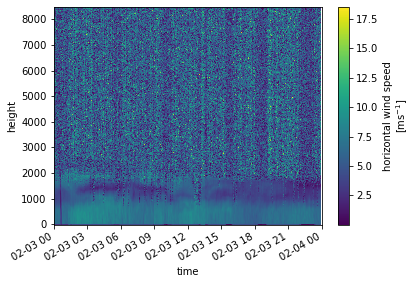

In [13]:
dataset_lidar_2.H_wind_speed.plot(x='time', y='height')
plt.xlim(datetime(2020,2,3,0,0,0), datetime(2020,2,4,0,0,0))

In [20]:
# reading now the entire horizontal wind dataset 
# read file Doppler lidar 
lidar_data = xr.open_dataset(path_h_wind+'Corrected_Horizontal_Wind_Speed_Direction_20Jan17Feb2020.nc')

# converting time from datenum to datetime format (for reference on how to do check https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python)
time_lidar = lidar_data.Time.values
python_datetime = []
for ind, time_val in enumerate(time_lidar):
    python_datetime.append(datetime.fromordinal(int(time_val)) + timedelta(days=time_val%1) - timedelta(days = 366))

# storing new variable in the xarray dataset
lidar_data['Time'] = python_datetime

# calculate time resolution
print('time res :'+str(np.ediff1d(python_datetime)[0]))

# creating a new dataset with proper coordinates, dimensions and variable names
dims             = ['time','height']
coords           = {"time":python_datetime, "height":lidar_data['Height'].values}
H_wind_speed     = xr.DataArray(dims=dims, coords=coords, data=lidar_data['Horizontal wind speed'].values,\
                     attrs={'long_name':'horizontal wind speed',\
                            'units':'ms$^{-1}$'})
H_wind_direction       = xr.DataArray(dims=dims, coords=coords, data=lidar_data['Horizontal wind direction'].values,\
                     attrs={'long_name':'horizontal wind direction',\
                            'units':'$^{\circ}$'})
global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                    'CREATED_ON'       :  str(datetime.now()),
                    'FILL_VALUE'       :  'NaN', 
                    'AUTHOR_NAME'          : 'Claudia Acquistapace',
                    'AUTHOR_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                    'AUTHOR_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                    'AUTHOR_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                    'DATA_DESCRIPTION' : 'doppler lidar data reformatted in a more convenient data format',
                    'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                    'DATA_GROUP'       : 'Experimental;Profile;Moving',
                    'DATA_SOURCE'      : 'Doppler lidar data',
                    'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                    'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                     'COMMENT'         : 'original data postprocessed by Florian Späth' }
dataset_lidar    = xr.Dataset(data_vars = {'H_wind_speed':H_wind_speed, 
                                    'H_wind_direction':H_wind_direction},
                                  coords = coords,
                                   attrs = global_attributes)

# interpolating dataset_lidar on the height of the small dataset, that has higher resolution
dataset_lidar = dataset_lidar.interp(height=dataset_lidar_2.height.values)

time res :0:01:33.691324


In [22]:
print(dataset_lidar['height'])
print(dataset_lidar_2['height'])

<xarray.DataArray 'height' (height: 400)>
array([   0.  ,   21.21,   42.42, ..., 8420.37, 8441.58, 8462.79])
Coordinates:
  * height   (height) float64 0.0 21.21 42.42 ... 8.42e+03 8.442e+03 8.463e+03
<xarray.DataArray 'height' (height: 400)>
array([   0.  ,   21.21,   42.42, ..., 8420.37, 8441.58, 8462.79])
Coordinates:
  * height   (height) float64 0.0 21.21 42.42 ... 8.42e+03 8.442e+03 8.463e+03


(18293.0, 18296.0)

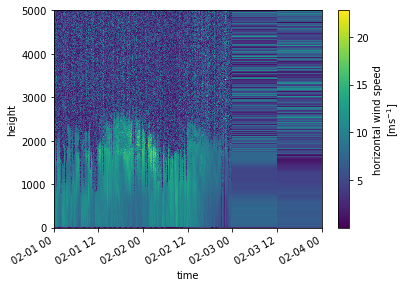

In [12]:
dataset_lidar.H_wind_speed.plot(x='time', y='height')
plt.xlim(datetime(2020,2,1,0,0,0), datetime(2020,2,4,0,0,0))

In [23]:
# cutting the lidar dataset in pieces so to then merge only the good data
time_cut_1_start = dataset_lidar.time.values[0]
time_cut_1_end = dataset_lidar_2.time.values[0]
print(time_cut_1_start, time_cut_1_end)
time_cut_2_start = dataset_lidar_2.time.values[-1]
time_cut_2_end = dataset_lidar.time.values[-1]
print(time_cut_2_start, time_cut_2_end)

# slicing the dataset
dataset_lidar_1 = dataset_lidar.sel(time=slice(time_cut_1_start, time_cut_1_end))
dataset_lidar_3 = dataset_lidar.sel(time=slice(time_cut_2_start, time_cut_2_end))


2020-01-20T00:01:35.101999000 2020-02-03T00:01:09.000000000
2020-02-03T23:56:34.000000000 2020-02-17T23:58:40.195333000


(18293.0, 18296.0)

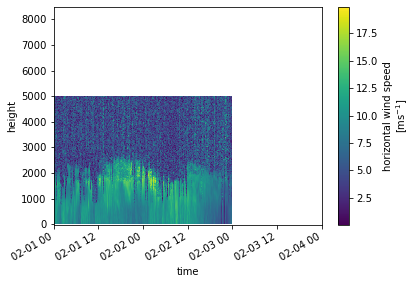

In [24]:
dataset_lidar_1.H_wind_speed.plot(x='time', y='height')
plt.xlim(datetime(2020,2,1,0,0,0), datetime(2020,2,4,0,0,0))


(18296.0, 18300.0)

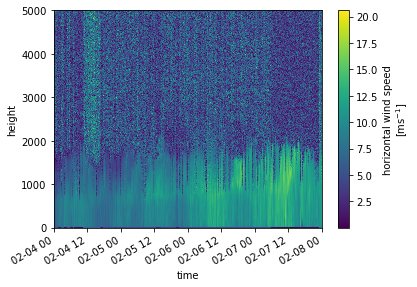

In [16]:
dataset_lidar_3.H_wind_speed.plot(x='time', y='height')
plt.xlim(datetime(2020,2,4,0,0,0), datetime(2020,2,8,0,0,0))

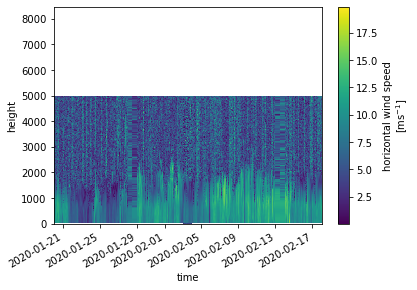

In [27]:

# merging the datasets
dataset_lidar_final = xr.concat([dataset_lidar_1, dataset_lidar_2, dataset_lidar_3], dim="time")

# cutting maximum height below 5000 m 
dataset_lidar_final = dataset_lidar_final.where(height < 5000.)

# saving to ncdf
path_out = path_h_wind
dataset_lidar_final.to_netcdf(path_out+'horizontal_wind_direction_msm_eurec4a_campaign.nc')
dataset_lidar_final.H_wind_speed.plot(x='time', y='height')

In [18]:
path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data_2/ARTHUS - DL/'
data = xr.open_dataset(path+'20200206_HALO_dt_ds_av.cdf')
data2 = xr.open_dataset(path+'20200218_TRRL_dt_ds_av.cdf')

FileNotFoundError: [Errno 2] No such file or directory: b'/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data_2/ARTHUS - DL/20200206_HALO_dt_ds_av.cdf'

In [15]:
print(24 *60 * 60 /10 )

8640.0


In [16]:
data.Time.values

array(['2020-02-06T00:00:00.000000000', '2020-02-06T00:10:00.000000000',
       '2020-02-06T00:20:00.000000000', '2020-02-06T00:30:00.000000000',
       '2020-02-06T00:40:00.000000000', '2020-02-06T00:50:00.000000000',
       '2020-02-06T01:00:00.000000000', '2020-02-06T01:10:00.000000000',
       '2020-02-06T01:20:00.000000000', '2020-02-06T01:30:00.000000000',
       '2020-02-06T01:40:00.000000000', '2020-02-06T01:50:00.000000000',
       '2020-02-06T02:00:00.000000000', '2020-02-06T02:10:00.000000000',
       '2020-02-06T02:20:00.000000000', '2020-02-06T02:30:00.000000000',
       '2020-02-06T02:40:00.000000000', '2020-02-06T02:50:00.000000000',
       '2020-02-06T03:00:00.000000000', '2020-02-06T03:10:00.000000000',
       '2020-02-06T03:20:00.000000000', '2020-02-06T03:30:00.000000000',
       '2020-02-06T03:40:00.000000000', '2020-02-06T03:50:00.000000000',
       '2020-02-06T04:00:00.000000000', '2020-02-06T04:10:00.000000000',
       '2020-02-06T04:20:00.000000000', '2020-02-06